In [1]:
# Uncomment the following to install Python denpendencies
! pip install pystac-client rioxarray geopandas matplotlib

## Seach satellite images

In [2]:
from pystac_client import Client 

In [3]:
# The URL of the data provider can be found at STAC Browser https://radiantearth.github.io/stac-browser/#/
api_url = 'https://earth-search.aws.element84.com/v1/'

client = Client.open(api_url)

for collection in client.get_collections():
    print(collection)

<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-1-grd>
<CollectionClient id=sentinel-2-c1-l2a>


In [4]:
from shapely.geometry import Point

# Create a shapely point on Rhodes
# WGS84 coordinates in (lon, lat) 
point = Point(27.95, 36.20)

search = client.search(
    collections=['sentinel-2-l2a'],
    intersects=point,
    datetime='2023-07-01/2023-08-31',
    query=['eo:cloud_cover<1'],
)

In [5]:
items_searched =  search.item_collection()
for item in items_searched:
    print(item)

<Item id=S2A_35SNA_20230827_0_L2A>
<Item id=S2B_35SNA_20230822_0_L2A>
<Item id=S2A_35SNA_20230817_0_L2A>
<Item id=S2B_35SNA_20230812_0_L2A>
<Item id=S2A_35SNA_20230807_0_L2A>
<Item id=S2B_35SNA_20230802_0_L2A>
<Item id=S2A_35SNA_20230728_0_L2A>
<Item id=S2B_35SNA_20230723_0_L2A>
<Item id=S2A_35SNA_20230718_0_L2A>
<Item id=S2B_35SNA_20230713_0_L2A>
<Item id=S2A_35SNA_20230708_0_L2A>


In [6]:
import pystac

# Select one image before and one after the fire event on July 23
# In this example we selected one on 20230827 and one on 20230708
items = pystac.ItemCollection([items_searched[0], items_searched[-1]])
for item in items:
    print(item)

<Item id=S2A_35SNA_20230827_0_L2A>
<Item id=S2A_35SNA_20230708_0_L2A>


In [7]:
# Save search results
items.save_object('rhodes_sentinel-2.json')

## Access searching results

In [8]:
import pystac

# Load search results
items = pystac.ItemCollection.from_file('rhodes_sentinel-2.json')

# Get the thumbnail URL of the first and last image
href_thumbnail_before = items[0].assets['thumbnail'].href
href_thumbnail_after = items[1].assets['thumbnail'].href

In [9]:
# Display the thumbnails before (click the link)
href_thumbnail_before

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/35/S/NA/2023/8/S2A_35SNA_20230827_0_L2A/thumbnail.jpg'

In [10]:
# Display the thumbnails after (click the link)
href_thumbnail_after

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/35/S/NA/2023/7/S2A_35SNA_20230708_0_L2A/thumbnail.jpg'

## Get the polygon of Rhodes Island

In [11]:
pass

## Crop satellite image

In [12]:
pass

In [13]:
import rioxarray

def get_band_and_clip(item, band_name, bbox, ov_level=1):
    href = item.assets[band_name].get_absolute_href()
    band = rioxarray.open_rasterio(href, masked=True, overview_level=ov_level)
    return band.rio.clip_box(*bbox)

## Calculate the fire index

In [14]:
# Functions imported from file? 

def burned_index(red, green, blue, nir, swir16, swir22):

    ndvi = (nir - red) / (nir + red)
    ndwi = (green - nir) / (green + nir)
    index = (swir16 - swir22) / (swir16 + swir22)

    index_match = index.rio.reproject_match(ndvi)
    swir16_match = swir16.rio.reproject_match(ndvi)

    burned = (
        (ndvi <= 0.3) &
        (ndwi <= 0.1) &
        ((index_match + nir/10000) <= 0.1) &
        ((blue/10000) <= 0.1) &
        ((swir16_match/10000) >= 0.1)
    )
    return burned

def plot_burned_index(burned_index, visual_href):
    """
    plot burned index over a true color image
    """
    burned_index = burned_index.squeeze()
    visual = rioxarray.open_rasterio(visual_href, overview_level=1)
    visual_clip = visual.rio.clip_box(*burned_index.rio.bounds())
    visual_clip[0] = visual_clip[0].where(~burned_index, 255)
    visual_clip[1:3] = visual_clip[1:3].where(~burned_index, 0)
    visual_clip.plot.imshow()

In [15]:
import rioxarray
red_before = rioxarray.open_rasterio(items[1].assets['red'].href, ov_level=2)

import geopandas as gpd
rhodes = gpd.read_file('rhodes.gpkg')
rhodes_reprojected = rhodes.to_crs(red_before.rio.crs)
bbox = rhodes_reprojected.total_bounds
bbox

array([ 561505.80329814, 3970451.33353859,  611872.89042946,
       4035463.69404871])

In [16]:
red_before = get_band_and_clip(items[1], 'red', bbox)
blue_before = get_band_and_clip(items[1], 'blue', bbox)
green_before = get_band_and_clip(items[1], 'green', bbox)
nir_before = get_band_and_clip(items[1], 'nir', bbox)
swir16_before = get_band_and_clip(items[1], 'swir16', bbox)
swir22_before = get_band_and_clip(items[1], 'swir22', bbox)

In [17]:
red_after = get_band_and_clip(items[0], 'red', bbox)
blue_after = get_band_and_clip(items[0], 'blue', bbox)
green_after = get_band_and_clip(items[0], 'green', bbox)
nir_after = get_band_and_clip(items[0], 'nir', bbox)
swir16_after = get_band_and_clip(items[0], 'swir16', bbox)
swir22_after = get_band_and_clip(items[0], 'swir22', bbox)


In [18]:
burned_index_before = burned_index(
    red_before, green_before, blue_before, nir_before, swir16_before, swir22_before
)

In [19]:
burned_index_after = burned_index(
    red_after, green_after, blue_after, nir_after, swir16_after, swir16_after
)

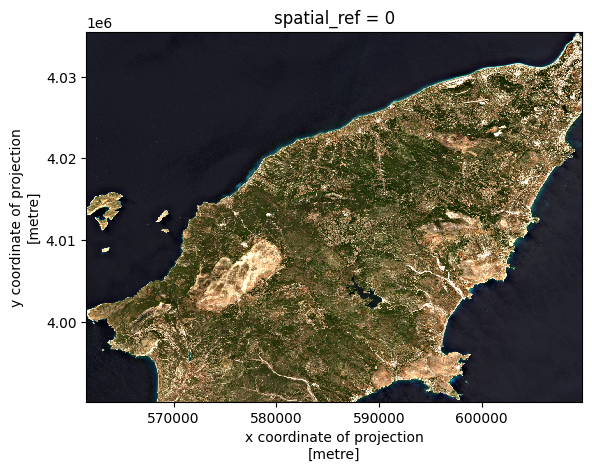

In [20]:
visual_href = item.assets['visual'].get_absolute_href()

plot_burned_index(burned_index_before, visual_href)

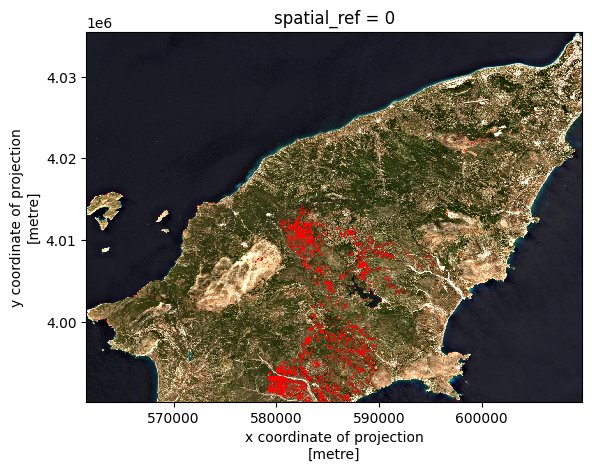

In [21]:
plot_burned_index(burned_index_after, visual_href)